In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import my_nb_path
import numpy as np
import matplotlib.pylab as plt

from pathlib import Path

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

In [3]:
from data.isic import get_isic_data
from eval.metrics import custom_metric
from data.preprocessing import preprocess
from data.column_names import cat_cols, norm_cols

In [4]:
root = Path('../../data/isic-2024/')
train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv' 

In [5]:
df_train, df_test = get_isic_data(train_path, test_path)

# Replace NaNs with the mean of each column
train_med = df_train[norm_cols].median()
df_train[norm_cols] = df_train[norm_cols].fillna(train_med)
df_test[norm_cols] = df_test[norm_cols].fillna(train_med)

In [6]:
df_train, df_test, feature_cols, cat_cols = preprocess(df_train, df_test, cat_cols)



/home/amir/source/Skin-Cancer-Detection/data/preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[new_cat_cols] = encoder.transform(df_train[col])
/home/amir/source/Skin-Cancer-Detection/data/preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[new_cat_cols] = encoder.transform(df_train[col])
/home/amir/source/Skin-Cancer-Detection/data/preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [7]:
cat_cols

['sex_0',
 'sex_1',
 'sex_2',
 'anatom_site_general_0',
 'anatom_site_general_1',
 'anatom_site_general_2',
 'anatom_site_general_3',
 'anatom_site_general_4',
 'anatom_site_general_5',
 'tbp_tile_type_0',
 'tbp_tile_type_1',
 'tbp_lv_location_0',
 'tbp_lv_location_1',
 'tbp_lv_location_2',
 'tbp_lv_location_3',
 'tbp_lv_location_4',
 'tbp_lv_location_5',
 'tbp_lv_location_6',
 'tbp_lv_location_7',
 'tbp_lv_location_8',
 'tbp_lv_location_9',
 'tbp_lv_location_10',
 'tbp_lv_location_11',
 'tbp_lv_location_12',
 'tbp_lv_location_13',
 'tbp_lv_location_14',
 'tbp_lv_location_15',
 'tbp_lv_location_16',
 'tbp_lv_location_17',
 'tbp_lv_location_18',
 'tbp_lv_location_19',
 'tbp_lv_location_20',
 'tbp_lv_location_simple_0',
 'tbp_lv_location_simple_1',
 'tbp_lv_location_simple_2',
 'tbp_lv_location_simple_3',
 'tbp_lv_location_simple_4',
 'tbp_lv_location_simple_5',
 'tbp_lv_location_simple_6',
 'tbp_lv_location_simple_7',
 'attribution_0',
 'attribution_1',
 'attribution_2',
 'attribution_3

In [8]:
len(feature_cols)

200

# Models

In [11]:
sampling_ratio = 0.01
seed = 142

target_col = 'target'
group_col = 'patient_id'

overSampler = None #RandomOverSampler(sampling_strategy= 0.005 , random_state=seed, shrinkage=None)
# underSampler = RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)
underSampler = None #NearMiss(sampling_strategy=0.005, n_neighbors=3, n_jobs=-1)

In [12]:
X = df_train[feature_cols]
y = df_train[target_col]
groups = df_train[group_col]
cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)

In [10]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           250,
    'boosting_type':    'gbdt',
    'random_state':     seed,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.03231007103195577, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}

lgb_model = Pipeline([
    ('sampler_1', overSampler),
    ('sampler_2', underSampler),
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])

In [11]:
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      seed,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}

cb_model = Pipeline([
    ('sampler_1', overSampler),
    ('sampler_2', underSampler),
    ('classifier', cb.CatBoostClassifier(**cb_params)),
])

In [12]:
xgb_params = {
    "objective": "binary:logistic",
    "n_estimators": 120,
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       seed,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          5, #6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
}

xgb_model = Pipeline([
    ('sampler_1', overSampler),
    ('sampler_2', underSampler),
    ('classifier', xgb.XGBClassifier(**xgb_params)),
])

In [13]:
estimator = VotingClassifier([
    ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
], voting='soft')

In [ ]:
val_score = cross_validate(
    estimator=estimator, 
    X=X, y=y, 
    cv=cv, 
    groups=groups,
    scoring=custom_metric,
    return_estimator=True
)

np.mean(val_score["test_score"]), val_score["test_score"]

/home/amir/miniconda3/envs/kaggle/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/amir/miniconda3/envs/kaggle/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/amir/miniconda3/envs/kaggle/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/amir/miniconda3/envs/kaggle/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/amir/miniconda3/envs/kaggle/lib/python3.12/site-pa

(0.1700601298651854,
 array([0.18273471, 0.15807478, 0.17226615, 0.17548764, 0.16173738]))

In [15]:
# (0.1709854947224229,
#  array([0.16357839, 0.17249376, 0.18518872, 0.16856942, 0.16509719]))
# (0.17034752750126442,
#  array([0.18195959, 0.15796467, 0.17405668, 0.17470634, 0.16305035]))
# (0.1700601298651854,
 # array([0.18273471, 0.15807478, 0.17226615, 0.17548764, 0.16173738]))

In [16]:
# Get columns with NaNs and the count of NaNs in each column
nan_columns = df_train.isna().sum()

# Filter to keep only columns that have NaNs
nan_columns = nan_columns[nan_columns > 0]

# Display the result
print(nan_columns)

Series([], dtype: int64)


In [17]:
val_score["estimator"]

[VotingClassifier(estimators=[('lgb',
                               Pipeline(steps=[('sampler_1', None),
                                               ('sampler_2', None),
                                               ('classifier',
                                                LGBMClassifier(bagging_fraction=0.7738954452473223,
                                                               bagging_freq=4,
                                                               colsample_bynode=0.4025961355653304,
                                                               colsample_bytree=0.8329551585827726,
                                                               lambda_l1=0.08758718919397321,
                                                               lambda_l2=0.0039689175176025465,
                                                               learning_rate=0.03231007103195577,
                                                               max_depth=4,...
                  

In [18]:
models = val_score["estimator"]

# Predict probabilities for each model on the test set
predictions = np.zeros((df_test.shape[0], len(models)))

for i, estimator in enumerate(models):
    predictions[:, i] = estimator.predict_proba(df_test[feature_cols])[:, 1]

# Combine the probabilities by averaging them
average_probabilities = np.mean(predictions, axis=1)

In [19]:
df_subm['target'] = average_probabilities #estimator.predict_proba(df_test[feature_cols])[:, 1]

df_subm.to_csv('submission.csv')
df_subm.head()

NameError: name 'df_subm' is not defined

In [ ]:
average_probabilities

In [13]:
sgkf = StratifiedGroupKFold(n_splits=5)

metrics = []
for train, val in sgkf.split(X, y, groups=groups):
    print("%s %s" % (train, val))
    
#     xtrain = X.iloc[train]
#     ytrain = y.iloc[train]
#     xval = X.iloc[val]
#     yval = y.iloc[val]
    
#     bst = xgb_model.fit(xtrain,
#                         ytrain, 
#                         verbose=2, 
#                         eval_set=[(xtrain, ytrain), (xval, yval)],
#                         )
#     metrics.append(custom_metric(bst, xval, yval))
# print(metrics)

[     0      1      2 ... 401056 401057 401058] [     6     11     15 ... 401048 401049 401050]
[     0      1      2 ... 401051 401053 401058] [     3      7     18 ... 401055 401056 401057]
[     0      2      3 ... 401055 401056 401057] [     1     12     25 ... 401045 401051 401058]
[     0      1      2 ... 401056 401057 401058] [     8      9     10 ... 401022 401025 401036]
[     1      3      6 ... 401056 401057 401058] [     0      2      4 ... 401031 401046 401053]


In [30]:
param = [
    ("max_depth", 2),
    ("objective", "binary:logistic"),
    ("eval_metric", "logloss"),
    ("eval_metric", "error"),
]

xgb_params = {
    "n_estimators":       120,
    # "num_parallel_tree": 10,
    'enable_categorical': True,
    # 'tree_method':        'hist',
    # "objective": "binary:logistic",
    "eval_metric": ["logloss", "auc"],
    # "eval_metric": "error",
    'random_state':       seed,
    'learning_rate':      0.08501257473292347, # 0.08
    # 'lambda':             8.879624125465703, 
    # 'alpha':              0.6779926606782505, 
    'max_depth':          5, #6, #5
    'subsample':          0.5 , #0.6012681388711075, # 0.5
    # 'colsample_bytree':   0.8437772277074493, 
    # 'colsample_bylevel':  0.5476090898823716, 
    # 'colsample_bynode':   0.9928601203635129, 
    # 'scale_pos_weight':   3.29440313334688,
}
xgb_model = xgb.XGBClassifier(**xgb_params)

num_round = 2
xtrain = X.iloc[train]
ytrain = y.iloc[train]
xval = X.iloc[val]
yval = y.iloc[val]
# watchlist = [(dtest, "eval"), (dtrain, "train")]

evals_result = {}
# bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result)
bst = xgb_model.fit(xtrain,
                    ytrain, 
                    verbose=2, 
                    eval_set=[(xtrain, ytrain), (xval, yval)],
                    )
custom_metric(bst, xval, yval)

[0]	validation_0-logloss:0.11839	validation_0-auc:0.69977	validation_1-logloss:0.11838	validation_1-auc:0.65273
[2]	validation_0-logloss:0.09939	validation_0-auc:0.86569	validation_1-logloss:0.09943	validation_1-auc:0.86446
[4]	validation_0-logloss:0.08367	validation_0-auc:0.89090	validation_1-logloss:0.08377	validation_1-auc:0.90497
[6]	validation_0-logloss:0.07063	validation_0-auc:0.89130	validation_1-logloss:0.07079	validation_1-auc:0.90394
[8]	validation_0-logloss:0.05977	validation_0-auc:0.90301	validation_1-logloss:0.05998	validation_1-auc:0.91796
[10]	validation_0-logloss:0.05072	validation_0-auc:0.90365	validation_1-logloss:0.05099	validation_1-auc:0.92029
[12]	validation_0-logloss:0.04317	validation_0-auc:0.90658	validation_1-logloss:0.04349	validation_1-auc:0.91872
[14]	validation_0-logloss:0.03686	validation_0-auc:0.90711	validation_1-logloss:0.03721	validation_1-auc:0.92071
[16]	validation_0-logloss:0.03158	validation_0-auc:0.90842	validation_1-logloss:0.03196	validation_1-

0.17513024207644395

In [31]:
bst
custom_metric(bst, xval, yval)

0.17513024207644395

#### results = bst.evals_result()

In [62]:
loss = results["validation_1"]["logloss"]
auc = results["validation_1"]["auc"]

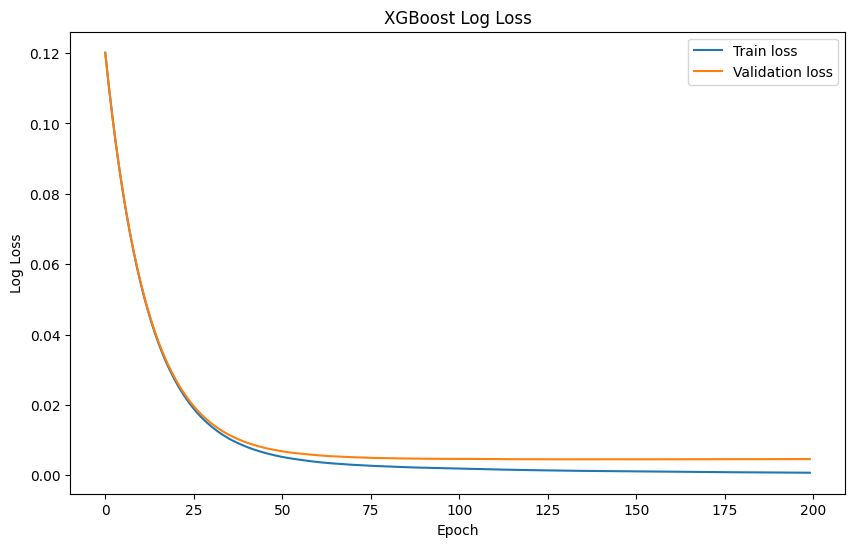

In [63]:
# Plot training and validation loss
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train loss')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.legend()
plt.show()

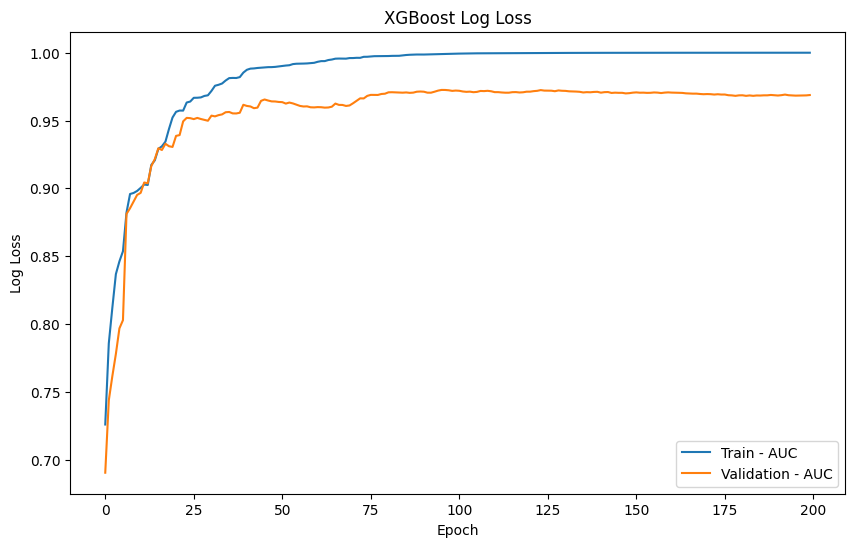

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['auc'], label='Train - AUC')
plt.plot(x_axis, results['validation_1']['auc'], label='Validation - AUC')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

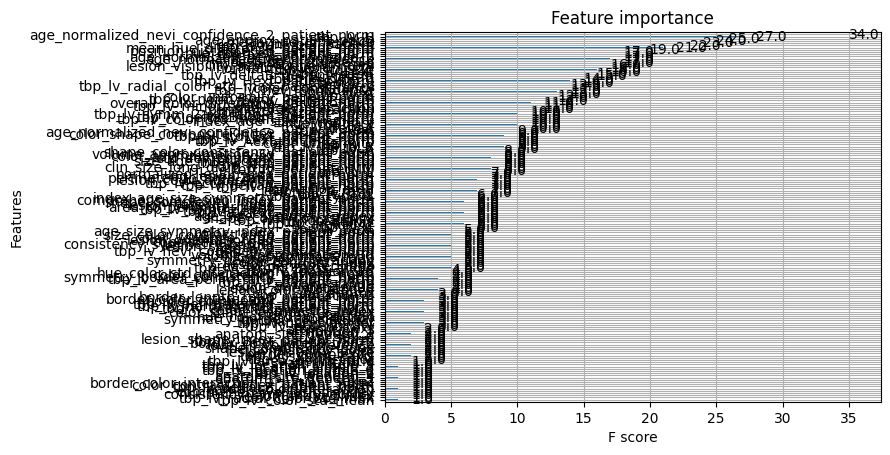

In [28]:
xgb.plot_importance(bst)